In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = '/content/drive/MyDrive/Prjct4_Split.zip'

import zipfile
import os

extract_path = '/content/drive/MyDrive'  # Directory where files will be extracted
os.makedirs(extract_path, exist_ok=True)  # Create the directory if it doesn't exist

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")

Files extracted to: /content/drive/MyDrive


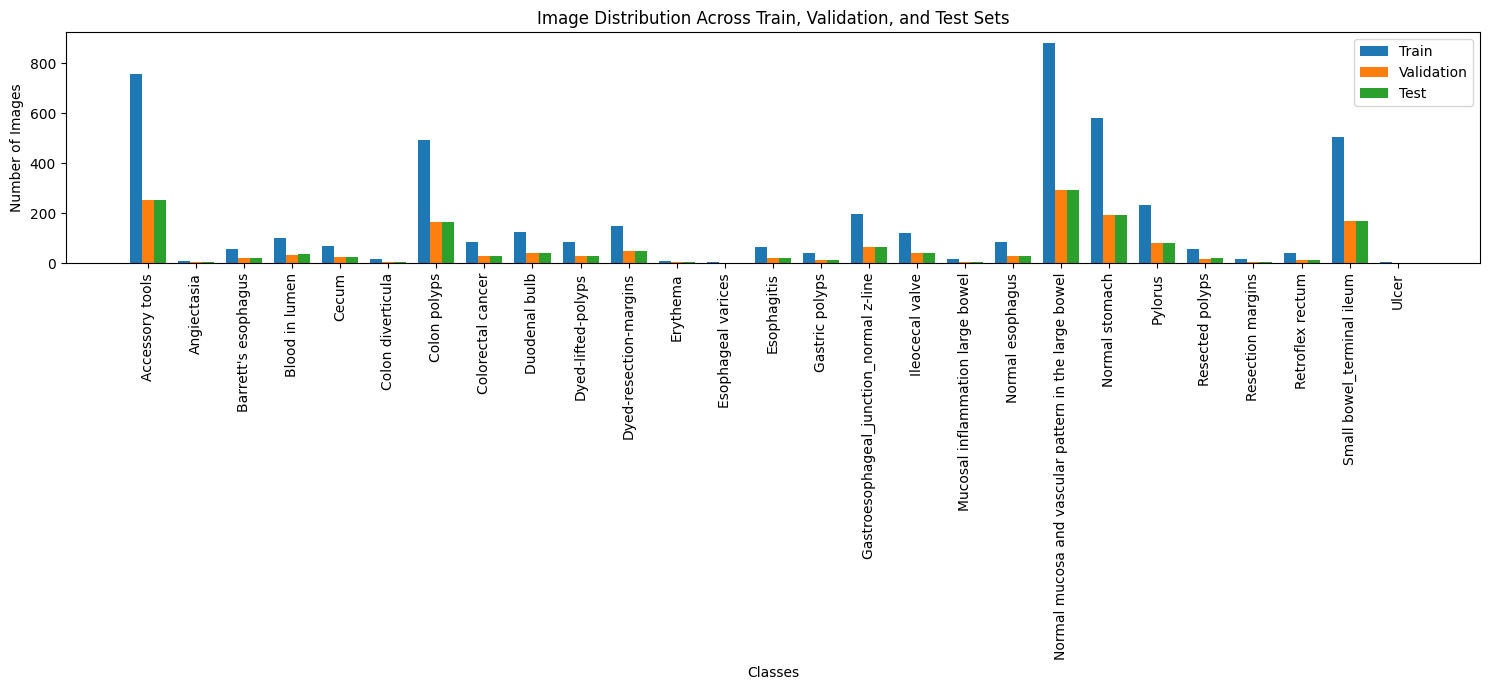

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Define the paths to the train, validation, and test directories
base_path = '/content/drive/MyDrive/Prjct4_Split'  # Update this path if different
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'val')
test_path = os.path.join(base_path, 'test')

# Function to count images in each class
def count_images(folder_path):
    class_counts = {}
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            class_counts[class_name] = len(os.listdir(class_folder))
    return class_counts

# Count images for each dataset
train_counts = count_images(train_path)
val_counts = count_images(val_path)
test_counts = count_images(test_path)

# Get the list of classes (assuming all sets have the same classes)
classes = sorted(train_counts.keys())

# Prepare data for the plot
train_data = [train_counts.get(cls, 0) for cls in classes]
val_data = [val_counts.get(cls, 0) for cls in classes]
test_data = [test_counts.get(cls, 0) for cls in classes]

# Plot the data
x = np.arange(len(classes))
width = 0.25

plt.figure(figsize=(15, 7))
plt.bar(x - width, train_data, width, label='Train')
plt.bar(x, val_data, width, label='Validation')
plt.bar(x + width, test_data, width, label='Test')

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Image Distribution Across Train, Validation, and Test Sets')
plt.xticks(x, classes, rotation=90)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score

# Paths to test directory
test_dir = os.path.join(base_path, 'test')

# Parameters
IMG_SIZE = 224  # Image size
BATCH_SIZE = 32
NUM_CLASSES = 27  # Number of classes

# Data Generator for Test Data
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Generate Random Predictions
y_true = test_generator.classes  # True labels
num_samples = len(y_true)
y_random = np.random.randint(0, NUM_CLASSES, size=num_samples)  # Random predictions

# Compute Accuracy
base_accuracy = accuracy_score(y_true, y_random)
print(f"Random Classifier Base Accuracy: {base_accuracy:.4f}")



Found 1610 images belonging to 27 classes.
Random Classifier Base Accuracy: 0.0385


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Multiply, Reshape, Softmax
from tensorflow.keras.layers import Attention, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

def attention_module(inputs):
    # Squeeze: Global Average Pooling
    avg_pool = GlobalAveragePooling2D()(inputs)
    avg_pool = Reshape((1, 1, avg_pool.shape[-1]))(avg_pool)

    # Excitation: Dense layers to generate attention weights
    dense_1 = Dense(units=inputs.shape[-1] // 8, activation='relu')(avg_pool)
    dense_2 = Dense(units=inputs.shape[-1], activation='sigmoid')(dense_1)

    # Scale: Multiply input features by attention weights
    attention = Multiply()([inputs, dense_2])
    return attention

def build_hierarchical_cnn(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # First Convolutional Block
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Attention Layer 1
    x = attention_module(x)

    # Second Convolutional Block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Attention Layer 2
    x = attention_module(x)

    # Third Convolutional Block
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Attention Layer 3
    x = attention_module(x)

    # Fully Connected Layers
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(train_path, target_size=(224, 224), batch_size=32, class_mode='categorical')
val_generator = datagen.flow_from_directory(val_path, target_size=(224, 224), batch_size=32, class_mode='categorical')
test_generator = datagen.flow_from_directory(test_path, target_size=(224, 224), batch_size=32, class_mode='categorical')



Found 4792 images belonging to 27 classes.
Found 1598 images belonging to 27 classes.
Found 1610 images belonging to 27 classes.


In [ ]:
input_shape = (224, 224, 3)  # Assuming RGB images
num_classes = len(train_generator.class_indices)

# Build the model
model = build_hierarchical_cnn(input_shape, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    verbose=1
)


Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 156s 913ms/step - accuracy: 0.2495 - loss: 3.0160 - val_accuracy: 0.0438 - val_loss: 5.3581
Epoch 2/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 124s 800ms/step - accuracy: 0.3220 - loss: 2.3931 - val_accuracy: 0.0907 - val_loss: 5.2043
Epoch 3/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 122s 787ms/step - accuracy: 0.3477 - loss: 2.2389 - val_accuracy: 0.2009 - val_loss: 3.1515
Epoch 4/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 126s 813ms/step - accuracy: 0.3672 - loss: 2.1893 - val_accuracy: 0.3880 - val_loss: 2.0630
Epoch 5/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 125s 805ms/step - accuracy: 0.3778 - loss: 2.0805 - val_accuracy: 0.4750 - val_loss: 1.7830
Epoch 6/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 122s 789ms/step - accuracy: 0.4093 - loss: 2.0128 - val_accuracy: 0.4887 - val_loss: 1.7502
Epoch 7/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 124s 797ms/step - accuracy: 0.3998 - loss: 2.0083 - val_accuracy: 0.4599 - val_loss: 1.8460
Epoch 8/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 122s 781ms/step - accuracy: 0.4317 - loss: 1.92

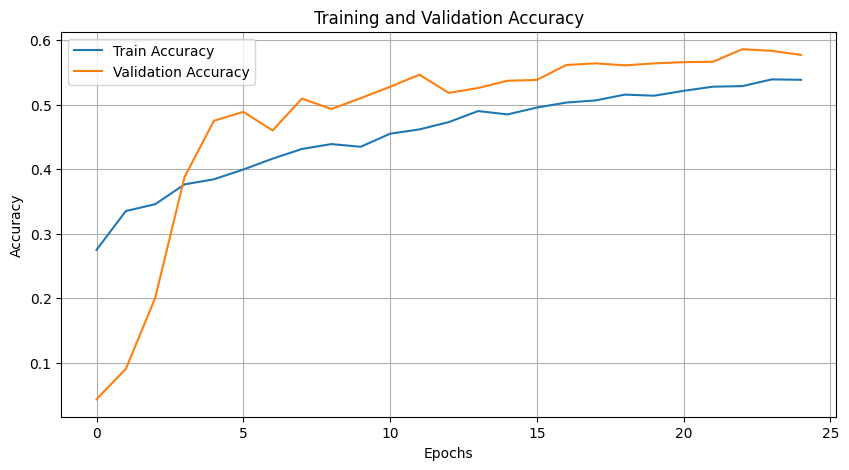

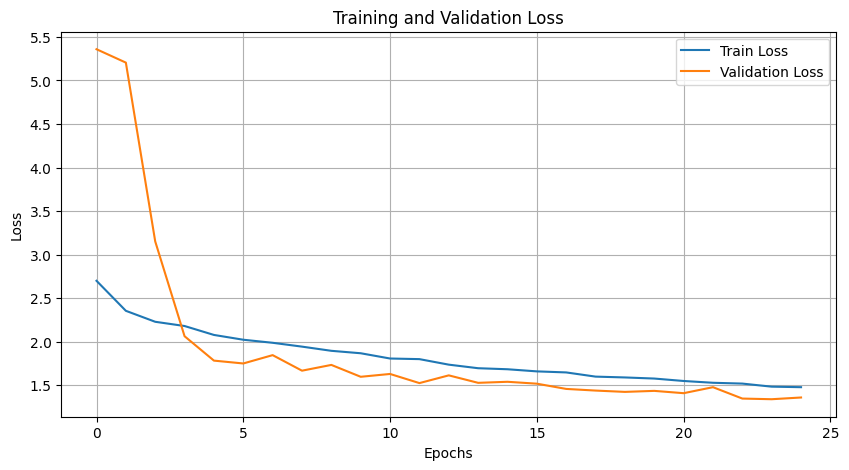

In [ ]:
import matplotlib.pyplot as plt

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


51/51 ━━━━━━━━━━━━━━━━━━━━ 32s 620ms/step - accuracy: 0.5625 - loss: 1.3819
Test Loss: 1.440603494644165
Test Accuracy: 0.54347825050354


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions for the test set
test_generator.reset()  # Reset the generator
y_pred = model.predict(test_generator, verbose=1)  # Predict probabilities
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices
y_true = test_generator.classes  # Get the true labels

# Class indices mapping
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print("Classification Report:")
report = classification_report(y_true, y_pred_classes, target_names=class_labels, digits=4)
print(report)


51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 573ms/step
Classification Report:
                                                       precision    recall  f1-score   support

                                      Accessory tools     0.1588    0.1457    0.1520       254
                                          Angiectasia     0.0000    0.0000    0.0000         4
                                  Barrett's esophagus     0.0000    0.0000    0.0000        19
                                       Blood in lumen     0.0588    0.0286    0.0385        35
                                                Cecum     0.0000    0.0000    0.0000        23
                                    Colon diverticula     0.0000    0.0000    0.0000         6
                                         Colon polyps     0.1066    0.0793    0.0909       164
                                    Colorectal cancer     0.0000    0.0000    0.0000        28
                                        Duodenal bulb     0.0000    0.0000    0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


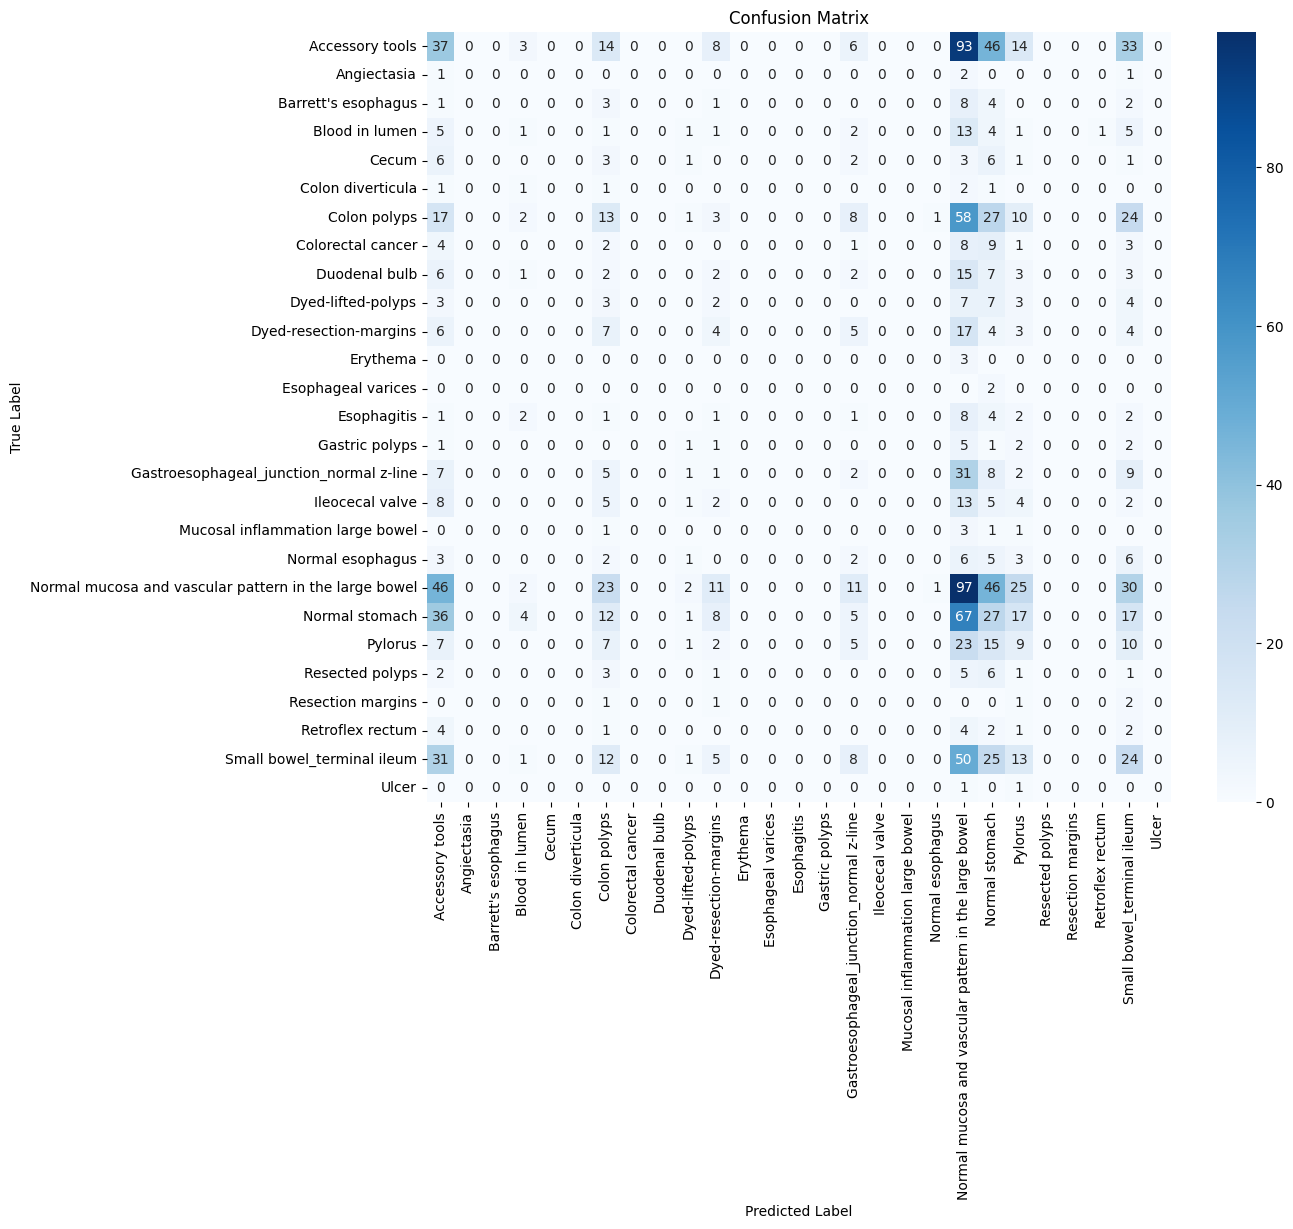

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns  # Optional for better visualization

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
from tensorflow.keras.applications import ConvNeXtBase
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def build_convnext_model(input_shape, num_classes):
    base_model = ConvNeXtBase(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model layers
    base_model.trainable = False

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model
input_shape = (224, 224, 3)  # Adjust if your images have a different shape
num_classes = len(train_generator.class_indices)

convnext_model = build_convnext_model(input_shape, num_classes)

convnext_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_convnext = convnext_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=1
)

# Fine-tune the ConvNeXt model
convnext_model.trainable = True
convnext_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune_convnext = convnext_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    verbose=1
)


350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step
Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 179s 972ms/step - accuracy: 0.0611 - loss: 3.7829 - val_accuracy: 0.1909 - val_loss: 2.5922
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 121s 781ms/step - accuracy: 0.1696 - loss: 2.8642 - val_accuracy: 0.2334 - val_loss: 2.5000
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 120s 777ms/step - accuracy: 0.1912 - loss: 2.7375 - val_accuracy: 0.2647 - val_loss: 2.4489
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 121s 777ms/step - accuracy: 0.2053 - loss: 2.6262 - val_accuracy: 0.2791 - val_loss: 2.3960
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 121s 778ms/step - accuracy: 0.2357 - loss: 2.5544 - val_accuracy: 0.2810 - val_loss: 2.3587
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 120s 771ms/step - accuracy: 0.2341 - loss: 2.5150 - val_accuracy: 0.3054 - val_loss: 2.3313
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 121s 777ms/step - accuracy: 0.2537 - loss: 2.4592 - val_accuracy: 0.3023 - val_loss: 2.3104
Epoch 8/10
150/150 ━━━

In [ ]:
# Evaluate ConvNeXt
test_loss_convnext, test_acc_convnext = convnext_model.evaluate(test_generator, verbose=1)
print(f"ConvNeXt - Test Loss: {test_loss_convnext:.4f}, Test Accuracy: {test_acc_convnext:.4f}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 42s 829ms/step - accuracy: 0.3295 - loss: 2.2277
ConvNeXt - Test Loss: 2.2436, Test Accuracy: 0.3441


In [ ]:
import os
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import DataLoader

# Paths to your datasets
train_path = '/content/drive/MyDrive/Prjct4_Split/train'
val_path = '/content/drive/MyDrive/Prjct4_Split/val'
test_path = '/content/drive/MyDrive/Prjct4_Split/test'

# Define image transformations
transform = Compose([
    Resize((224, 224)),  # Resize to Swin's input size
    ToTensor(),          # Convert to PyTorch tensors
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize RGB channels
])

# Load datasets
train_dataset = ImageFolder(train_path, transform=transform)
val_dataset = ImageFolder(val_path, transform=transform)
test_dataset = ImageFolder(test_path, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Get the number of classes
num_classes = len(train_dataset.classes)
print(f"Number of Classes: {num_classes}")


Number of Classes: 27


In [ ]:
from transformers import SwinForImageClassification, SwinConfig

# Load Swin Transformer with a classification head for your dataset
config = SwinConfig.from_pretrained("microsoft/swin-base-patch4-window7-224", num_labels=num_classes)
swin_model = SwinForImageClassification(config)


In [ ]:
import torch
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from transformers import get_scheduler

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
swin_model.to(device)

# Optimizer and learning rate scheduler
optimizer = AdamW(swin_model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 10  # Assume 10 epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Loss function
loss_fn = CrossEntropyLoss()


In [ ]:
swin_model.train()

for epoch in range(10):  # Number of epochs
    print(f"Epoch {epoch + 1}")
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()

        # Move inputs and labels to the device
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = swin_model(pixel_values=inputs, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # Backward pass
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1} Loss: {total_loss / len(train_loader)}")


Epoch 1
Epoch 1 Loss: 2.1262897713979085
Epoch 2
Epoch 2 Loss: 1.7447854495048523
Epoch 3
Epoch 3 Loss: 1.5772604974110922
Epoch 4
Epoch 4 Loss: 1.4571114309628805
Epoch 5
Epoch 5 Loss: 1.382364890575409
Epoch 6
Epoch 6 Loss: 1.2947341748078665
Epoch 7
Epoch 7 Loss: 1.2110132161776226
Epoch 8
Epoch 8 Loss: 1.129691069126129
Epoch 9
Epoch 9 Loss: 1.0551939205328624
Epoch 10
Epoch 10 Loss: 0.9843688746293385


In [ ]:
from sklearn.metrics import accuracy_score

swin_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = swin_model(pixel_values=inputs)
        preds = torch.argmax(outputs.logits, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 60.56%


In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import DataLoader
import os

# Paths
train_path = '/content/drive/MyDrive/Prjct4_Split/train'

# Transformations for GAN input
gan_transform = Compose([
    Resize((64, 64)),  # Resize images to a smaller size for GAN training
    ToTensor(),        # Convert to tensor
    Normalize([0.5], [0.5])  # Normalize to [-1, 1] for tanh activation
])

# Load dataset
dataset = ImageFolder(train_path, transform=gan_transform)

# Create DataLoader
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)


In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=4, stride=1, padding=0),  # Output: (512, 4, 4)
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # Output: (256, 8, 8)
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Output: (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 32, 32)
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1),  # Output: (img_channels, 64, 64)
            nn.Tanh()  # Normalize output to [-1, 1]
        )

    def forward(self, z):
        return self.model(z)


In [ ]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, img_channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),  # Feature map to 1x1
        )
        self.flatten = nn.Flatten()  # Flatten output to [batch_size, 1]
        self.sigmoid = nn.Sigmoid()  # Output single probability per image

    def forward(self, img):
        x = self.model(img)
        x = self.flatten(x)
        return self.sigmoid(x)


In [ ]:
import torch.optim as optim

# Hyperparameters
latent_dim = 100
img_channels = 3  # RGB images
epochs = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
generator = Generator(latent_dim, img_channels).to(device)
discriminator = Discriminator(img_channels).to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
adversarial_loss = nn.BCELoss()


In [ ]:
for epoch in range(epochs):
    for real_imgs, _ in data_loader:
        real_imgs = real_imgs.to(device)

        # Labels for real and fake images
        real = torch.ones((real_imgs.size(0), 1), device=device)
        fake = torch.zeros((real_imgs.size(0), 1), device=device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn((real_imgs.size(0), latent_dim, 1, 1), device=device)  # Random noise
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), real)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"Epoch {epoch + 1}/{epochs} | Generator Loss: {g_loss.item():.4f} | Discriminator Loss: {d_loss.item():.4f}")


Epoch 1/200 | Generator Loss: 4.0705 | Discriminator Loss: 0.1265
Epoch 2/200 | Generator Loss: 2.1806 | Discriminator Loss: 0.1155
Epoch 3/200 | Generator Loss: 3.7098 | Discriminator Loss: 0.1028
Epoch 4/200 | Generator Loss: 2.5020 | Discriminator Loss: 0.1503
Epoch 5/200 | Generator Loss: 4.9835 | Discriminator Loss: 0.0146
Epoch 6/200 | Generator Loss: 4.2567 | Discriminator Loss: 0.1959
Epoch 7/200 | Generator Loss: 4.4156 | Discriminator Loss: 0.1234
Epoch 8/200 | Generator Loss: 0.9929 | Discriminator Loss: 0.4107
Epoch 9/200 | Generator Loss: 2.8360 | Discriminator Loss: 0.0710
Epoch 10/200 | Generator Loss: 4.6481 | Discriminator Loss: 0.0302
Epoch 11/200 | Generator Loss: 2.2336 | Discriminator Loss: 0.1315
Epoch 12/200 | Generator Loss: 1.2173 | Discriminator Loss: 0.3515
Epoch 13/200 | Generator Loss: 2.5313 | Discriminator Loss: 0.1418
Epoch 14/200 | Generator Loss: 2.1379 | Discriminator Loss: 0.1276
Epoch 15/200 | Generator Loss: 2.2115 | Discriminator Loss: 0.1650
Epoc

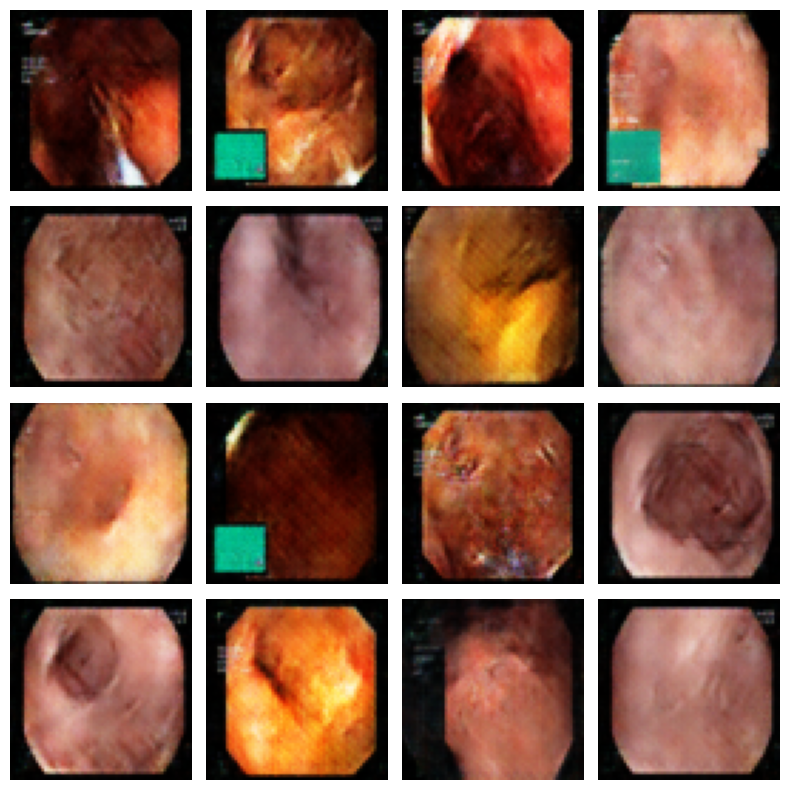

In [ ]:
import matplotlib.pyplot as plt

# Generate synthetic images
generator.eval()
z = torch.randn((16, latent_dim, 1, 1), device=device)
gen_imgs = generator(z)
gen_imgs = gen_imgs.permute(0, 2, 3, 1).cpu().detach().numpy()  # Rearrange dimensions for plotting

# Plot synthetic images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    img = (gen_imgs[i] * 0.5 + 0.5)  # Denormalize to [0, 1]
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# Generate synthetic images
generator.eval()
z = torch.randn(16, latent_dim, 1, 1, device=device)  # Generate 16 random images
gen_imgs = generator(z).detach()

# Ensure the images are still PyTorch tensors
gen_imgs = (gen_imgs * 0.5) + 0.5  # Denormalize from [-1, 1] to [0, 1]

# Resize images for Inception model
gen_imgs_resized = torch.nn.functional.interpolate(gen_imgs, size=(299, 299), mode='bilinear', align_corners=False)


In [ ]:
from torchvision.models import inception_v3
import torch.nn.functional as F

def calculate_inception_score(images, batch_size=32, splits=10):
    # Load Inception model
    model = inception_v3(pretrained=True, transform_input=False).eval().to(device)

    # Resize images for Inception model
    images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)

    # Get predictions
    preds = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size].to(device)
        preds.append(F.softmax(model(batch), dim=1).detach().cpu())
    preds = torch.cat(preds, dim=0)

    # Calculate scores
    split_scores = []
    for k in range(splits):
        part = preds[k * (len(images) // splits): (k+1) * (len(images) // splits), :]
        py = torch.mean(part, dim=0)
        scores = torch.sum(part * (torch.log(part) - torch.log(py)), dim=1)
        split_scores.append(torch.exp(torch.mean(scores)))
    return torch.mean(torch.tensor(split_scores)), torch.std(torch.tensor(split_scores))

# Example usage
gen_imgs_resized = gen_imgs  # Resize to match inception model requirements if needed
is_mean, is_std = calculate_inception_score(gen_imgs_resized)
print(f"Inception Score: {is_mean:.4f} ± {is_std:.4f}")


Inception Score: 1.0000 ± 0.0000


In [ ]:
from scipy.linalg import sqrtm
import numpy as np

def calculate_fid(real_images, generated_images, model):
    # Resize real and generated images to (299, 299)
    real_images = torch.nn.functional.interpolate(real_images, size=(299, 299), mode='bilinear', align_corners=False)
    generated_images = torch.nn.functional.interpolate(generated_images, size=(299, 299), mode='bilinear', align_corners=False)

    # Calculate activations for real and generated images
    with torch.no_grad():
        real_activations = model(real_images).detach().cpu().numpy()
        gen_activations = model(generated_images).detach().cpu().numpy()

    # Calculate mean and covariance
    mu_real, sigma_real = np.mean(real_activations, axis=0), np.cov(real_activations, rowvar=False)
    mu_gen, sigma_gen = np.mean(gen_activations, axis=0), np.cov(gen_activations, rowvar=False)

    # Calculate FID score
    mean_diff = mu_real - mu_gen
    cov_mean = sqrtm(sigma_real.dot(sigma_gen))
    if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real
    fid = np.sum(mean_diff**2) + np.trace(sigma_real + sigma_gen - 2 * cov_mean)
    return fid

# Example Usage
real_imgs = next(iter(data_loader))[0].to(device)  # Load a batch of real images
fid_score = calculate_fid(real_imgs, gen_imgs, inception_model)
print(f"FID Score: {fid_score:.4f}")


FID Score: 1134.0515


In [ ]:
# Calculate pixel-wise variance across generated images
variance = torch.var(gen_imgs, dim=0).mean().item()
print(f"Pixel Variance Across Generated Images: {variance:.4f}")


Pixel Variance Across Generated Images: 0.0366


In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import DataLoader

# Paths to your dataset
train_path = '/content/drive/MyDrive/Prjct4_Split/train'
val_path = '/content/drive/MyDrive/Prjct4_Split/val'
test_path = '/content/drive/MyDrive/Prjct4_Split/test'

# Define image transformations
transform = Compose([
    Resize((224, 224)),  # Resize images to ViT's input size
    ToTensor(),          # Convert images to PyTorch tensors
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Load datasets
train_dataset = ImageFolder(train_path, transform=transform)
val_dataset = ImageFolder(val_path, transform=transform)
test_dataset = ImageFolder(test_path, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Get the number of classes
num_classes = len(train_dataset.classes)
print(f"Number of Classes: {num_classes}")


Number of Classes: 27


In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
import os

# Paths to train, validation, and test directories

train_dir= '/content/drive/MyDrive/Prjct4_Split/train'
val_dir = '/content/drive/MyDrive/Prjct4_Split/val'
test_dir = '/content/drive/MyDrive/Prjct4_Split/test'


# Parameters
IMG_SIZE = 224  # Image size for ViT
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 27
LEARNING_RATE = 1e-4

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Preprocessing
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Datasets and Dataloaders
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load Pre-trained ViT model
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=NUM_CLASSES
)
model = model.cuda()  # Move model to GPU

# Optimizer and Loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training Loop
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(pixel_values=inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {train_loss/len(train_loader):.4f}, Accuracy: {train_acc:.4f}")

    # Validation Loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(pixel_values=inputs).logits
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_acc:.4f}")

# Testing Loop
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(pixel_values=inputs).logits
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Loss: 1.6886, Accuracy: 0.6077
Validation Loss: 1.0524, Validation Accuracy: 0.7541
Epoch 2/10, Loss: 0.8434, Accuracy: 0.8074
Validation Loss: 0.7731, Validation Accuracy: 0.8054
Epoch 3/10, Loss: 0.5370, Accuracy: 0.8731
Validation Loss: 0.6801, Validation Accuracy: 0.8185
Epoch 4/10, Loss: 0.3759, Accuracy: 0.9071
Validation Loss: 0.6767, Validation Accuracy: 0.8198
Epoch 5/10, Loss: 0.2272, Accuracy: 0.9489
Validation Loss: 0.6820, Validation Accuracy: 0.8223
Epoch 6/10, Loss: 0.1648, Accuracy: 0.9626
Validation Loss: 0.7100, Validation Accuracy: 0.8267
Epoch 7/10, Loss: 0.1073, Accuracy: 0.9781
Validation Loss: 1.0274, Validation Accuracy: 0.7672
Epoch 8/10, Loss: 0.0856, Accuracy: 0.9823
Validation Loss: 0.8585, Validation Accuracy: 0.8016
Epoch 9/10, Loss: 0.0998, Accuracy: 0.9762
Validation Loss: 0.8579, Validation Accuracy: 0.8110
Epoch 10/10, Loss: 0.0935, Accuracy: 0.9752
Validation Loss: 0.8160, Validation Accuracy: 0.8110
Test Accuracy: 0.8006


In [ ]:

# Testing Loop with Metrics Calculation
model.eval()
test_loss = 0.0
correct = 0
total = 0

# Initialize lists to store all labels and predictions
all_test_labels = []
all_test_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(pixel_values=inputs).logits
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Append ground truth and predictions for metrics
        all_test_labels.extend(labels.cpu().numpy())
        all_test_predictions.extend(predicted.cpu().numpy())

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

# Precision, Recall, and F1-Score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

precision = precision_score(all_test_labels, all_test_predictions, average='weighted')
recall = recall_score(all_test_labels, all_test_predictions, average='weighted')
f1 = f1_score(all_test_labels, all_test_predictions, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed Classification Report
class_names = test_dataset.classes  # Get class names from the dataset
print("\nClassification Report:")
print(classification_report(all_test_labels, all_test_predictions, target_names=class_names))


Test Accuracy: 0.8006
Precision: 0.7965
Recall: 0.8006
F1 Score: 0.7917

Classification Report:
                                                       precision    recall  f1-score   support

                                      Accessory tools       0.95      0.93      0.94       254
                                          Angiectasia       0.33      0.25      0.29         4
                                  Barrett's esophagus       0.70      0.37      0.48        19
                                       Blood in lumen       0.76      0.74      0.75        35
                                                Cecum       0.00      0.00      0.00        23
                                    Colon diverticula       1.00      0.50      0.67         6
                                         Colon polyps       0.80      0.70      0.74       164
                                    Colorectal cancer       0.47      0.54      0.50        28
                                        Duodenal

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

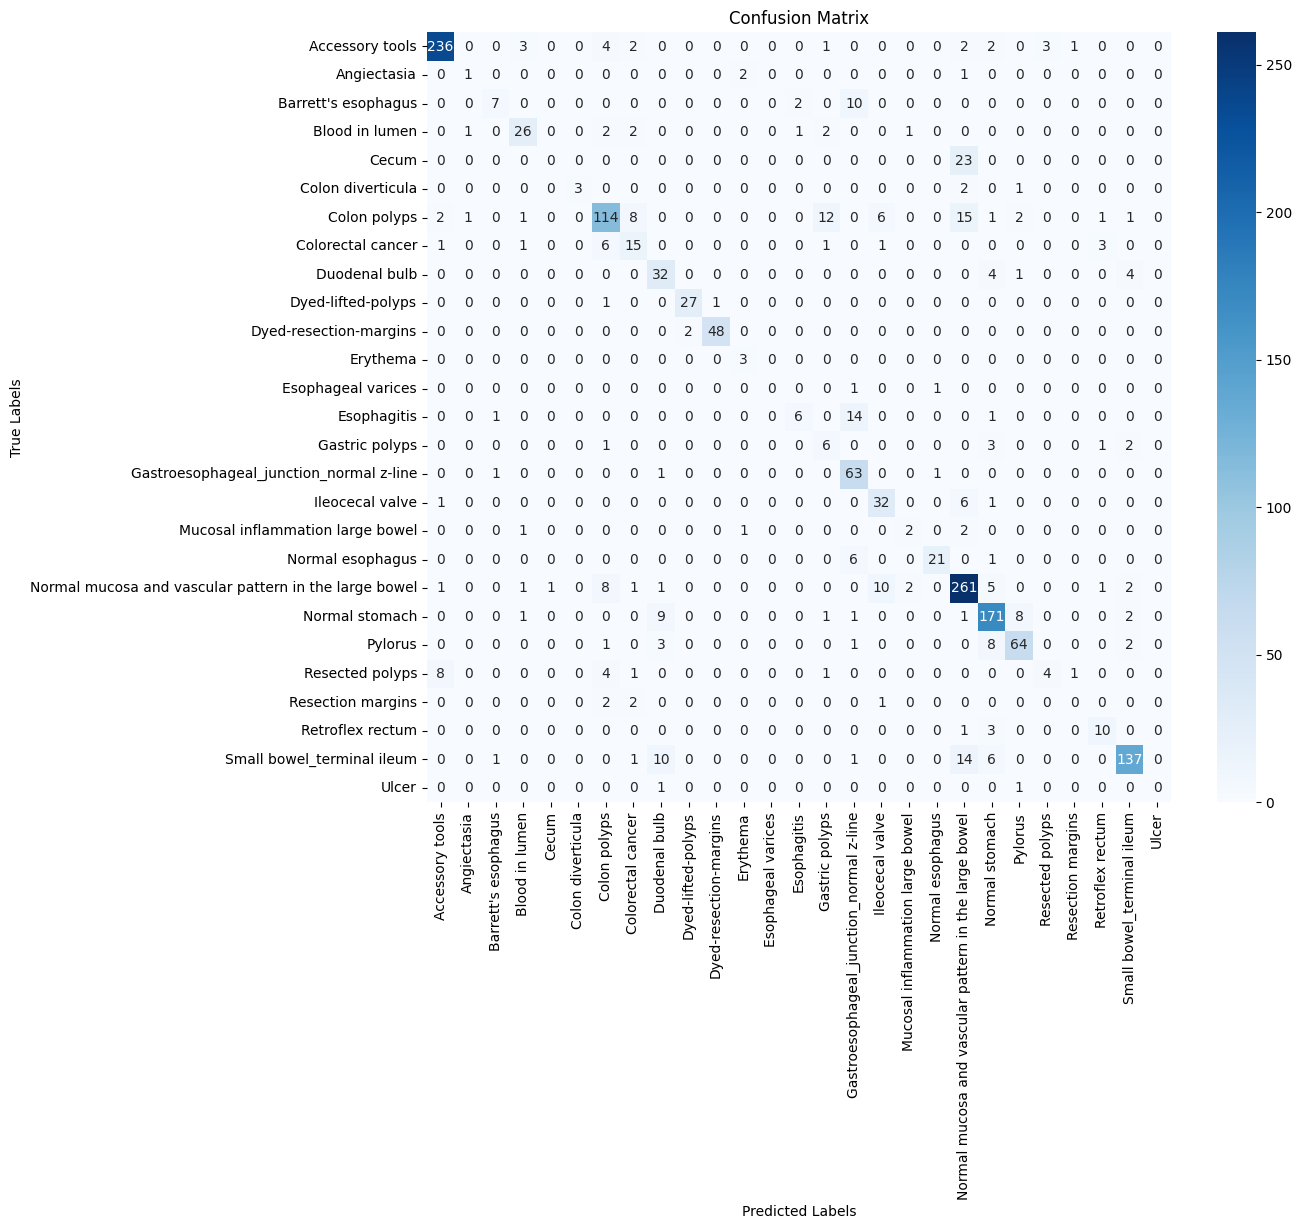

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
conf_matrix = confusion_matrix(all_test_labels, all_test_predictions)

# Plot Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


In [ ]:
# Save the trained model
save_path = '/content/drive/MyDrive/trained_vit_model.pth'  # Replace with your desired save location
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")


Model saved to /content/drive/MyDrive/trained_vit_model.pth


In [ ]:
from torchvision import datasets

# Path to the training directory
train_dir = '/content/drive/MyDrive/Prjct4_Split/train'

# Load the training dataset
train_dataset = datasets.ImageFolder(root=train_dir)

# Get the class names
class_names = train_dataset.classes

# Print the class names
print(f"Number of classes: {len(class_names)}")
print("Class Names:")
for idx, class_name in enumerate(class_names):
    print(f"{idx}: {class_name}")


Number of classes: 27
Class Names:
0: Accessory tools
1: Angiectasia
2: Barrett's esophagus
3: Blood in lumen
4: Cecum
5: Colon diverticula
6: Colon polyps
7: Colorectal cancer
8: Duodenal bulb
9: Dyed-lifted-polyps
10: Dyed-resection-margins
11: Erythema
12: Esophageal varices
13: Esophagitis
14: Gastric polyps
15: Gastroesophageal_junction_normal z-line
16: Ileocecal valve
17: Mucosal inflammation large bowel
18: Normal esophagus
19: Normal mucosa and vascular pattern in the large bowel
20: Normal stomach
21: Pylorus
22: Resected polyps
23: Resection margins
24: Retroflex rectum
25: Small bowel_terminal ileum
26: Ulcer


In [ ]:
# Mapping of class indices to their respective categories
class_to_category = {
    0: "Benign",
    1: "Low-Risk",
    2: "Low-Risk",
    3: "High-Risk",
    4: "Benign",
    5: "Benign",
    6: "Low-Risk",
    7: "Malignant",
    8: "Benign",
    9: "Low-Risk",
    10: "Low-Risk",
    11: "Benign",
    12: "High-Risk",
    13: "Low-Risk",
    14: "Low-Risk",
    15: "Benign",
    16: "Benign",
    17: "Low-Risk",
    18: "Benign",
    19: "Benign",
    20: "Benign",
    21: "Benign",
    22: "Low-Risk",
    23: "Low-Risk",
    24: "Low-Risk",
    25: "Benign",
    26: "High-Risk",
}


In [ ]:
import torch
from transformers import ViTForImageClassification

# Function to classify and group into categories
def classify_and_group(model, dataloader, class_to_category):
    all_preds = []
    all_probs = []
    all_labels = []
    all_categories = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            # Forward pass
            outputs = model(pixel_values=inputs).logits
            probabilities = torch.softmax(outputs, dim=1)  # Convert logits to probabilities

            # Predicted class and corresponding probabilities
            preds = torch.argmax(probabilities, dim=1)  # Predicted class
            max_probs = torch.max(probabilities, dim=1).values  # Probability of the predicted class

            # Map predictions to categories
            categories = [class_to_category[p.item()] for p in preds]

            # Store predictions, probabilities, labels, and categories
            all_preds.extend(preds.numpy())
            all_probs.extend(max_probs.numpy())
            all_labels.extend(labels.numpy())
            all_categories.extend(categories)

    return all_preds, all_probs, all_labels, all_categories

# Example usage on the test set
test_preds, test_probs, test_labels, test_categories = classify_and_group(model, test_loader, class_to_category)

# Display a few results
for i in range(10):  # Display the first 10 samples
    print(
        f"Predicted = {test_dataset.classes[test_preds[i]]}, "
        f"Category = {test_categories[i]}, "
        f"Probability = {test_probs[i]:.4f}"
    )




Predicted = Angiectasia, Category = Low-Risk, Probability = 0.0471
Predicted = Accessory tools, Category = Benign, Probability = 0.0466
Predicted = Blood in lumen, Category = High-Risk, Probability = 0.0488
Predicted = Blood in lumen, Category = High-Risk, Probability = 0.0457
Predicted = Esophageal varices, Category = High-Risk, Probability = 0.0465
Predicted = Blood in lumen, Category = High-Risk, Probability = 0.0463
Predicted = Barrett's esophagus, Category = Low-Risk, Probability = 0.0427
Predicted = Angiectasia, Category = Low-Risk, Probability = 0.0439
Predicted = Blood in lumen, Category = High-Risk, Probability = 0.0448
Predicted = Blood in lumen, Category = High-Risk, Probability = 0.0481


In [ ]:
import torch

# Forward pass to get logits
outputs = model(pixel_values=inputs).logits

# Apply softmax to calculate probabilities
probabilities = torch.softmax(outputs, dim=1)

# Extract probabilities for each class
benign_prob = probabilities[:, 0]
low_risk_prob = probabilities[:, 1]
high_risk_prob = probabilities[:, 2]
malignant_prob = probabilities[:, 3]

# Example likelihood score (malignant class)
for i in range(len(inputs)):
    print(f"Sample {i+1}: Malignancy Likelihood = {malignant_prob[i].item() * 100:.2f}%")


Sample 1: Malignancy Likelihood = 3.43%
Sample 2: Malignancy Likelihood = 3.24%
Sample 3: Malignancy Likelihood = 3.11%
Sample 4: Malignancy Likelihood = 3.99%
Sample 5: Malignancy Likelihood = 3.95%
Sample 6: Malignancy Likelihood = 3.63%
Sample 7: Malignancy Likelihood = 4.50%
Sample 8: Malignancy Likelihood = 4.59%
Sample 9: Malignancy Likelihood = 3.94%
Sample 10: Malignancy Likelihood = 4.20%


In [ ]:
# Define timelines for each category
category_timelines = {
    "Benign": {
        "follow_up": "3–5 years",
        "intervention_needed": False,
        "note": "Benign lesions typically do not progress and require minimal monitoring."
    },
    "Low-Risk": {
        "follow_up": "2–3 years",
        "intervention_needed": False,
        "note": "Low-risk lesions progress slowly and require periodic surveillance."
    },
    "High-Risk": {
        "follow_up": "6–12 months",
        "intervention_needed": True,
        "note": "High-risk lesions can progress to malignancy within months and require timely follow-up or intervention."
    },
    "Malignant": {
        "follow_up": "Immediate intervention",
        "intervention_needed": True,
        "note": "Malignant lesions progress rapidly and need urgent treatment."
    },
}

# Function to get timeline details for a category
def get_category_timeline(category):
    if category in category_timelines:
        timeline = category_timelines[category]
        print(f"Category: {category}")
        print(f"Follow-Up Interval: {timeline['follow_up']}")
        print(f"Intervention Needed: {'Yes' if timeline['intervention_needed'] else 'No'}")
        print(f"Note: {timeline['note']}")
    else:
        print(f"Category '{category}' not recognized.")

# Example usage
categories_to_check = ["Benign", "Low-Risk", "High-Risk", "Malignant"]

for category in categories_to_check:
    print("\n-------------------------------")
    get_category_timeline(category)



-------------------------------
Category: Benign
Follow-Up Interval: 3–5 years
Intervention Needed: No
Note: Benign lesions typically do not progress and require minimal monitoring.

-------------------------------
Category: Low-Risk
Follow-Up Interval: 2–3 years
Intervention Needed: No
Note: Low-risk lesions progress slowly and require periodic surveillance.

-------------------------------
Category: High-Risk
Follow-Up Interval: 6–12 months
Intervention Needed: Yes
Note: High-risk lesions can progress to malignancy within months and require timely follow-up or intervention.

-------------------------------
Category: Malignant
Follow-Up Interval: Immediate intervention
Intervention Needed: Yes
Note: Malignant lesions progress rapidly and need urgent treatment.


In [ ]:
# Define timelines for each category
category_timelines = {
    "Benign": {
        "follow_up": "3–5 years",
        "intervention_needed": False,
        "note": "Benign lesions typically do not progress and require minimal monitoring."
    },
    "Low-Risk": {
        "follow_up": "2–3 years",
        "intervention_needed": False,
        "note": "Low-risk lesions progress slowly and require periodic surveillance."
    },
    "High-Risk": {
        "follow_up": "6–12 months",
        "intervention_needed": True,
        "note": "High-risk lesions can progress to malignancy within months and require timely follow-up or intervention."
    },
    "Malignant": {
        "follow_up": "Immediate intervention",
        "intervention_needed": True,
        "note": "Malignant lesions progress rapidly and need urgent treatment."
    },
}

# Function to link timeline details with debugging
def get_category_timeline(category):
    if category in category_timelines:
        return category_timelines[category]
    else:
        print(f"DEBUG: Category '{category}' not found in category_timelines.")
        return None

# Select 2 samples from the test dataset
sample_indices = [0, 1]  # Change indices as needed
for i in sample_indices:
    true_label = test_dataset.classes[test_labels[i]]
    predicted_label = test_dataset.classes[test_preds[i]]
    category = test_categories[i]
    probability = test_probs[i] * 100  # Convert to percentage

    # Get timeline details
    timeline_details = get_category_timeline(category)
    if timeline_details is None:
        print(f"ERROR: No timeline found for category '{category}'")
        continue

    # Print results
    print(f"Sample {i+1}:")
    print(f"  True Label: {true_label}")
    print(f"  Predicted: {predicted_label}")
    print(f"  Category: {category}")
    print(f"  Probability of Predicted Class: {probability:.2f}%")
    print(f"  Follow-Up Interval: {timeline_details['follow_up']}")
    print(f"  Intervention Needed: {'Yes' if timeline_details['intervention_needed'] else 'No'}")
    print(f"  Note: {timeline_details['note']}")
    print("-------------------------------------------------------------")


Sample 1:
  True Label: Accessory tools
  Predicted: Angiectasia
  Category: Low-Risk
  Probability of Predicted Class: 4.71%
  Follow-Up Interval: 2–3 years
  Intervention Needed: No
  Note: Low-risk lesions progress slowly and require periodic surveillance.
-------------------------------------------------------------
Sample 2:
  True Label: Accessory tools
  Predicted: Accessory tools
  Category: Benign
  Probability of Predicted Class: 4.66%
  Follow-Up Interval: 3–5 years
  Intervention Needed: No
  Note: Benign lesions typically do not progress and require minimal monitoring.
-------------------------------------------------------------
